In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy import coordinates, table
from shapely.geometry import Point
from matplotlib.patches import Circle
import healpy as hp
import healsparse
from astropy.table import Table, join

plt.style.use('mplstyle')

### Load the exposures that qualify to Merian DR1

In [2]:
db_file = '/Users/yifei/Dropbox/merian/db_merian.fits'

data = fits.getdata(db_file, 1)
db = table.Table(data).to_pandas()
db_DR1 = db[db['expnum'] < 1087049] # this only include DR1 exposures
#db_DR1 = db[db['expnum'] < 108704900] # give a very large number to include all exposures 

# N708 filter
db_n708 = db_DR1[db_DR1['band']=='N708']
db_n708 = db_n708[db_n708['exptime']>300]
db_n708.loc[db_n708['racenter'] > 300, 'ra_neg'] = db_n708['racenter']-360
db_n708.loc[db_n708['racenter'] < 300, 'ra_neg'] = db_n708['racenter']

# N540 filter
db_n540 = db_DR1[db_DR1['band']=='N540']
db_n540 = db_n540[db_n540['exptime']>300]
db_n540.loc[db_n540['racenter'] > 300, 'ra_neg'] = db_n540['racenter']-360
db_n540.loc[db_n540['racenter'] < 300, 'ra_neg'] = db_n540['racenter']

### Calculate t_eff (N708 and N540)

In [3]:
transparency_0 = 1.
seeing_0 = 1.
skySB_0_N708 = 20.9
skySB_0_N540 = 22.1

transparency = db['transparency']
seeing = db['seeing']
sky = db['sky']

db_n708['t_eff'] = (db_n708['transparency']/transparency_0)**2*(db_n708['seeing']/seeing_0)**(-2)*(10**((db_n708['sky']-skySB_0_N708)/2.5))*db_n708['exptime']
db_n540['t_eff'] = (db_n540['transparency']/transparency_0)**2*(db_n540['seeing']/seeing_0)**(-2)*(10**((db_n540['sky']-skySB_0_N540)/2.5))*db_n540['exptime']

### Make a t_eff map

#### N708 Spring

In [6]:
texp_N708 = 600*4 #sec
texp_N540 = 900*4 #sec
teff_ratio = 0.5
print("Teff ratio:",teff_ratio)

res_grid = 0.01  # 0.01 here is 36 arcsec
print("Resolution (in simple grid):",res_grid*60*60,"arcsec")
N_side = 4096 # make this resolution slightly larger than the grid resolution
print("Resolution with N_side {} in healpix is {:.2} arcsec".format(N_side, hp.nside2resol(N_side, arcmin=True)*60))

Teff ratio: 0.5
Resolution (in simple grid): 36.0 arcsec
Resolution with N_side 4096 in healpix is 5.2e+01 arcsec


In [7]:
%%time
ra_bins = np.arange(120,240,res_grid) 
dec_bins = np.arange(-5,6,res_grid)

ra_ind = np.arange(0,len(ra_bins),1)
dec_ind = np.arange(0,len(dec_bins),1)

coords = np.array(np.meshgrid(ra_bins, dec_bins)).T.reshape(-1,2)
indx = np.array(np.meshgrid(ra_ind, dec_ind)).T.reshape(-1,2)

data = {'ra':  coords[:,0],
        'dec': coords[:,1],
        'texp': coords[:,1]-coords[:,1],
        'teff': coords[:,1]-coords[:,1],
        'incircle' : coords[:,1]-coords[:,1],
        'ra_ind': indx[:,0],
        'dec_ind': indx[:,1]
        }
df = pd.DataFrame(data)

circle_radius = (3.18/pi)**0.5

patches = []
circles_matplotlib = []
circles = [Point(db_n708['racenter'].to_numpy()[i],
                 db_n708['deccenter'].to_numpy()[i]).buffer(circle_radius) for i in range(len(db_n708))]
for i in range(len(db_n708)):
    circle = Circle((db_n708['racenter'].to_numpy()[i],db_n708['deccenter'].to_numpy()[i]),circle_radius)
    circles_matplotlib.append(circle)
    patches.append(circle)

for c in range(len(circles_matplotlib[0:-1])):
    in_or_not = circles_matplotlib[c].contains_points(coords)
    df.loc[:,'incircle'] = in_or_not
    df.loc[df['incircle']==True,'texp'] = df.loc[df['incircle']==True,'texp'] + db_n708['exptime'].to_numpy()[c]
    df.loc[df['incircle']==True,'teff'] = df.loc[df['incircle']==True,'teff'] + db_n708['t_eff'].to_numpy()[c]

    tot_t_eff_n708_spring = np.zeros((len(dec_bins),len(ra_bins)))

for i in range(len(df)):
    tot_t_eff_n708_spring[df['dec_ind'][i]][df['ra_ind'][i]] = df['teff'][i]

CPU times: user 4min 19s, sys: 7.74 s, total: 4min 27s
Wall time: 4min 13s


teff_ratio: 0.5
Resolution with N_side 4096 in healpix is 5.2e+01 arcsec


setting the output map dtype to [dtype('float64')]


Total unmasked area: 267.66 square degrees


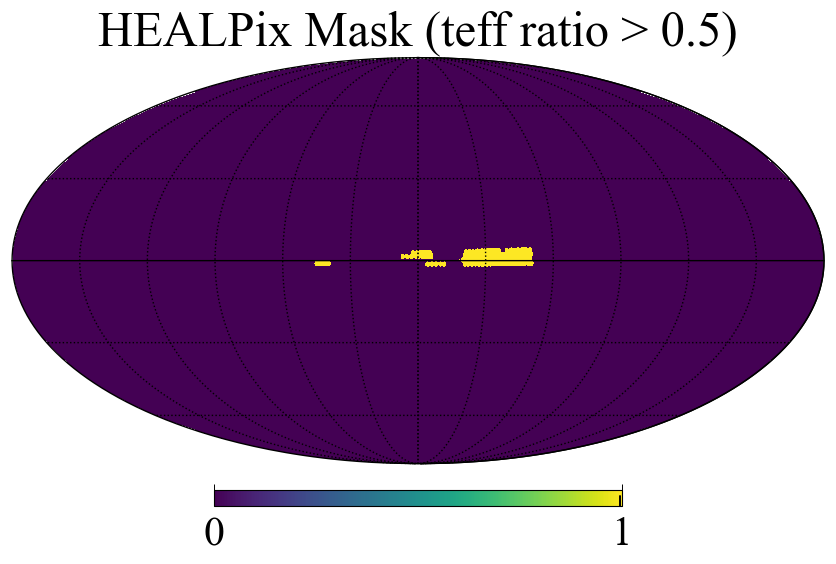

In [8]:
print("teff_ratio:",teff_ratio)
print("Resolution with N_side {} in healpix is {:.2} arcsec".format(N_side, hp.nside2resol(N_side, arcmin=True)*60))

RA_deg, Dec_deg = np.meshgrid(ra_bins, dec_bins)
RA_rad = np.radians(RA_deg.flatten()) 
Dec_rad = np.radians(Dec_deg.flatten())

theta = np.pi / 2 - Dec_rad
phi = RA_rad
pix_indices = hp.ang2pix(N_side, theta, phi)
teff_values = tot_t_eff_n708_spring.flatten()
max_teff_per_pixel = {}

for idx, teff in zip(pix_indices, teff_values):
    if idx in max_teff_per_pixel:
        max_teff_per_pixel[idx] = max(max_teff_per_pixel[idx], teff)
    else:
        max_teff_per_pixel[idx] = teff

healpix_mask = np.zeros(hp.nside2npix(N_side))

# Set mask to 1.0 for pixels with teff > texp*teff_ratio
for pixel_idx, max_teff in max_teff_per_pixel.items():
    if max_teff >= (texp_N708*teff_ratio):
        healpix_mask[pixel_idx] = 1.0

hp.mollview(healpix_mask, title="HEALPix Mask (teff ratio > {})".format(teff_ratio),
            rot=[-180, 0], norm="hist", cmap='viridis', min=0, max=1)
hp.graticule()

pix_area_sq_deg = hp.nside2pixarea(N_side, degrees=True)
unmasked_pixels_count = np.sum(healpix_mask == 1)
total_unmasked_area_sq_deg = unmasked_pixels_count * pix_area_sq_deg
print(f"Total unmasked area: {total_unmasked_area_sq_deg:.2f} square degrees")

hp.write_map("N708_Spring_teff{}.fits".format(teff_ratio), healpix_mask, overwrite=True)

#### N540 Spring

In [9]:
%%time
ra_bins = np.arange(120,240,res_grid) # 0.01 here is 36 arcsec
dec_bins = np.arange(-5,6,res_grid)

ra_ind = np.arange(0,len(ra_bins),1)
dec_ind = np.arange(0,len(dec_bins),1)

coords = np.array(np.meshgrid(ra_bins, dec_bins)).T.reshape(-1,2)
indx = np.array(np.meshgrid(ra_ind, dec_ind)).T.reshape(-1,2)

data_n540_spring = {'ra':  coords[:,0],
        'dec': coords[:,1],
        'texp': coords[:,1]-coords[:,1],
        'teff': coords[:,1]-coords[:,1],
        'incircle' : coords[:,1]-coords[:,1],
        'ra_ind': indx[:,0],
        'dec_ind': indx[:,1]
        }
df_n540_spring = pd.DataFrame(data)

circle_radius = (3.18/pi)**0.5

patches_n540_spring = []
circles_matplotlib_n540_spring = []
circles_n540_spring = [Point(db_n540['racenter'].to_numpy()[i],
                 db_n540['deccenter'].to_numpy()[i]).buffer(circle_radius) for i in range(len(db_n540))]
for i in range(len(db_n540)):
    circle = Circle((db_n540['racenter'].to_numpy()[i],db_n540['deccenter'].to_numpy()[i]),circle_radius)
    circles_matplotlib_n540_spring.append(circle)
    patches_n540_spring.append(circle)

for c in range(len(circles_matplotlib_n540_spring[0:-1])):
    in_or_not = circles_matplotlib_n540_spring[c].contains_points(coords)
    df_n540_spring.loc[:,'incircle'] = in_or_not
    df_n540_spring.loc[df_n540_spring['incircle']==True,'texp'] = df_n540_spring.loc[df_n540_spring['incircle']==True,'texp'] + db_n540['exptime'].to_numpy()[c]
    df_n540_spring.loc[df_n540_spring['incircle']==True,'teff'] = df_n540_spring.loc[df_n540_spring['incircle']==True,'teff'] + db_n540['t_eff'].to_numpy()[c]

    
    tot_t_eff_n540_spring = np.zeros((len(dec_bins),len(ra_bins)))


for i in range(len(df_n540_spring)):
    tot_t_eff_n540_spring[df_n540_spring['dec_ind'][i]][df_n540_spring['ra_ind'][i]] = df_n540_spring['teff'][i]

CPU times: user 4min 32s, sys: 7.84 s, total: 4min 40s
Wall time: 4min 24s


teff_ratio: 0.5
Resolution with N_side 4096 in healpix is 5.2e+01 arcsec


setting the output map dtype to [dtype('float64')]


Total unmasked area: 231.01 square degrees


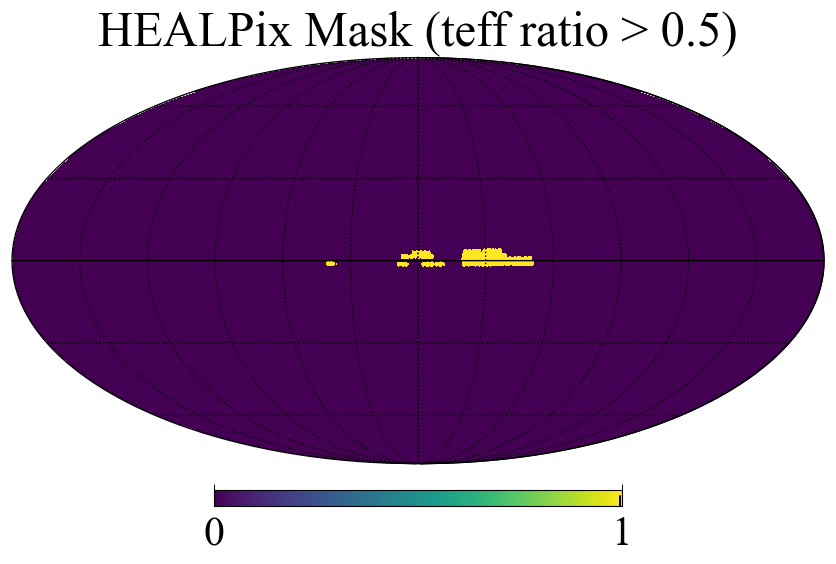

In [10]:
print("teff_ratio:",teff_ratio)
print("Resolution with N_side {} in healpix is {:.2} arcsec".format(N_side, hp.nside2resol(N_side, arcmin=True)*60))

RA_deg, Dec_deg = np.meshgrid(ra_bins, dec_bins)
RA_rad = np.radians(RA_deg.flatten())
Dec_rad = np.radians(Dec_deg.flatten())

theta = np.pi / 2 - Dec_rad
phi = RA_rad

pix_indices = hp.ang2pix(N_side, theta, phi)
teff_values = tot_t_eff_n540_spring.flatten()
max_teff_per_pixel = {}

for idx, teff in zip(pix_indices, teff_values):
    if idx in max_teff_per_pixel:
        max_teff_per_pixel[idx] = max(max_teff_per_pixel[idx], teff)
    else:
        max_teff_per_pixel[idx] = teff

healpix_mask = np.zeros(hp.nside2npix(N_side))

# Set mask to 1.0 for pixels with teff > texp*teff_ratio
for pixel_idx, max_teff in max_teff_per_pixel.items():
    if max_teff >= (texp_N540*teff_ratio):
        healpix_mask[pixel_idx] = 1.0

hp.mollview(healpix_mask, title="HEALPix Mask (teff ratio > {})".format(teff_ratio),
            rot=[-180, 0], norm="hist", cmap='viridis', min=0, max=1)
hp.graticule()

pix_area_sq_deg = hp.nside2pixarea(N_side, degrees=True)
unmasked_pixels_count = np.sum(healpix_mask == 1)
total_unmasked_area_sq_deg = unmasked_pixels_count * pix_area_sq_deg
print(f"Total unmasked area: {total_unmasked_area_sq_deg:.2f} square degrees")

hp.write_map("N540_Spring_teff{}.fits".format(teff_ratio), healpix_mask, overwrite=True)

### Fall N708

In [11]:
%%time
# N708
ra_bins = np.arange(-40,50,res_grid)
# ra_bins = ra_bins-360
dec_bins = np.arange(-7,7,res_grid)
ra_ind = np.arange(0,len(ra_bins),1)
dec_ind = np.arange(0,len(dec_bins),1)
coords = np.array(np.meshgrid(ra_bins, dec_bins)).T.reshape(-1,2)
indx = np.array(np.meshgrid(ra_ind, dec_ind)).T.reshape(-1,2)

data = {'ra':  coords[:,0],
        'dec': coords[:,1],
        'texp': coords[:,1]-coords[:,1],
        'teff': coords[:,1]-coords[:,1],
        'incircle' : coords[:,1]-coords[:,1],
        'ra_ind': indx[:,0],
        'dec_ind': indx[:,1]
        }

df = pd.DataFrame(data)
patches = []
circles_matplotlib = []
circles = [Point(db_n708['ra_neg'].to_numpy()[i],
                 db_n708['deccenter'].to_numpy()[i]).buffer(circle_radius) for i in range(len(db_n708))]

for i in range(len(db_n708)):
    circle = Circle((db_n708['ra_neg'].to_numpy()[i],db_n708['deccenter'].to_numpy()[i]),circle_radius)
    circles_matplotlib.append(circle)
    patches.append(circle)

for c in range(len(circles_matplotlib[0:-1])):
    in_or_not = circles_matplotlib[c].contains_points(coords)
    df.loc[:,'incircle'] = in_or_not
    df.loc[df['incircle']==True,'texp'] = df.loc[df['incircle']==True,'texp'] + db_n708['exptime'].to_numpy()[c]
    df.loc[df['incircle']==True,'teff'] = df.loc[df['incircle']==True,'teff'] + db_n708['t_eff'].to_numpy()[c]
    tot_t_eff_n708_fall = np.zeros((len(dec_bins),len(ra_bins)))

for i in range(len(df)):
    tot_t_eff_n708_fall[df['dec_ind'][i]][df['ra_ind'][i]] = df['teff'][i]
    
tot_t_eff_n708_fall[tot_t_eff_n708_fall ==0] = np.nan

CPU times: user 4min 12s, sys: 7.93 s, total: 4min 20s
Wall time: 4min 6s


teff_ratio: 0.5
Resolution with N_side 4096 in healpix is 5.2e+01 arcsec


setting the output map dtype to [dtype('float64')]


Total unmasked area: 39.30 square degrees


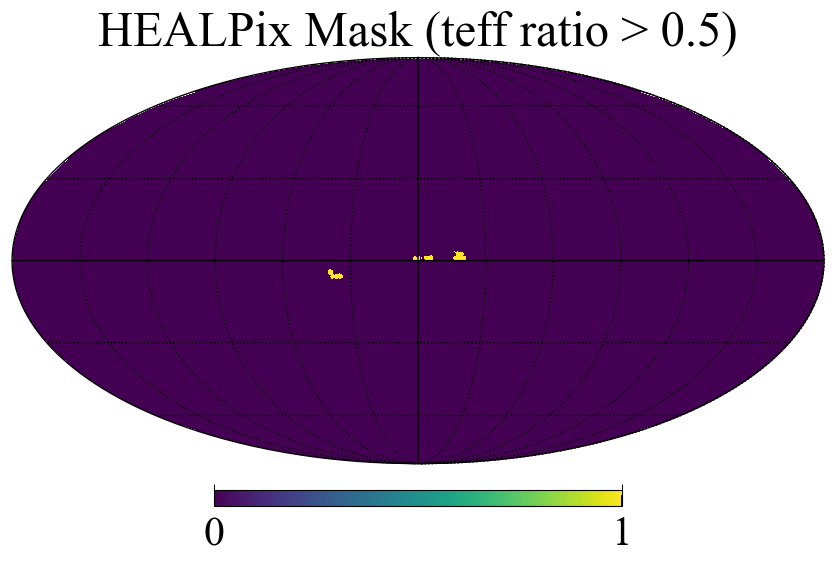

In [12]:
print("teff_ratio:",teff_ratio)
print("Resolution with N_side {} in healpix is {:.2} arcsec".format(N_side, hp.nside2resol(N_side, arcmin=True)*60))

RA_deg, Dec_deg = np.meshgrid(ra_bins, dec_bins)
RA_rad = np.radians(RA_deg.flatten())  # Convert to radians for HEALPy
Dec_rad = np.radians(Dec_deg.flatten())

theta = np.pi / 2 - Dec_rad
phi = RA_rad

pix_indices = hp.ang2pix(N_side, theta, phi)
teff_values = tot_t_eff_n708_fall.flatten()
max_teff_per_pixel = {}

for idx, teff in zip(pix_indices, teff_values):
    if idx in max_teff_per_pixel:
        max_teff_per_pixel[idx] = max(max_teff_per_pixel[idx], teff)
    else:
        max_teff_per_pixel[idx] = teff

healpix_mask = np.zeros(hp.nside2npix(N_side))

for pixel_idx, max_teff in max_teff_per_pixel.items():
    if max_teff > (texp_N708*teff_ratio):
        healpix_mask[pixel_idx] = 1.0

hp.mollview(healpix_mask, title="HEALPix Mask (teff ratio > {})".format(teff_ratio),
            rot=[0, 0], norm="hist", cmap='viridis', min=0, max=1)
hp.graticule()

pix_area_sq_deg = hp.nside2pixarea(N_side, degrees=True)
unmasked_pixels_count = np.sum(healpix_mask == 1)
total_unmasked_area_sq_deg = unmasked_pixels_count * pix_area_sq_deg
print(f"Total unmasked area: {total_unmasked_area_sq_deg:.2f} square degrees")

hp.write_map("N708_Fall_teff{}_2024.fits".format(teff_ratio), healpix_mask, overwrite=True)

# Fall N540

In [13]:
%%time
ra_bins = np.arange(-40,50,res_grid)
# ra_bins = ra_bins-360
dec_bins = np.arange(-7,7,res_grid)
ra_ind = np.arange(0,len(ra_bins),1)
dec_ind = np.arange(0,len(dec_bins),1)
coords = np.array(np.meshgrid(ra_bins, dec_bins)).T.reshape(-1,2)
indx = np.array(np.meshgrid(ra_ind, dec_ind)).T.reshape(-1,2)

data = {'ra':  coords[:,0],
        'dec': coords[:,1],
        'texp': coords[:,1]-coords[:,1],
        'teff': coords[:,1]-coords[:,1],
        'incircle' : coords[:,1]-coords[:,1],
        'ra_ind': indx[:,0],
        'dec_ind': indx[:,1]
        }
df = pd.DataFrame(data)
patches = []
circles_matplotlib = []
circles = [Point(db_n540['ra_neg'].to_numpy()[i],
                 db_n540['deccenter'].to_numpy()[i]).buffer(circle_radius) for i in range(len(db_n540))]
for i in range(len(db_n540)):
    circle = Circle((db_n540['ra_neg'].to_numpy()[i],db_n540['deccenter'].to_numpy()[i]),circle_radius)
    circles_matplotlib.append(circle)
    patches.append(circle)

for c in range(len(circles_matplotlib[0:-1])):
    in_or_not = circles_matplotlib[c].contains_points(coords)
    df.loc[:,'incircle'] = in_or_not
    df.loc[df['incircle']==True,'texp'] = df.loc[df['incircle']==True,'texp'] + db_n540['exptime'].to_numpy()[c]
    df.loc[df['incircle']==True,'teff'] = df.loc[df['incircle']==True,'teff'] + db_n540['t_eff'].to_numpy()[c]
    tot_t_eff_n540_fall = np.zeros((len(dec_bins),len(ra_bins)))

for i in range(len(df)):
    tot_t_eff_n540_fall[df['dec_ind'][i]][df['ra_ind'][i]] = df['teff'][i]
tot_t_eff_n540_fall[tot_t_eff_n540_fall ==0] = np.nan

CPU times: user 4min 24s, sys: 8.86 s, total: 4min 33s
Wall time: 4min 19s


teff_ratio: 0.5
Resolution with N_side 4096 in healpix is 5.2e+01 arcsec


setting the output map dtype to [dtype('float64')]


Total unmasked area: 73.38 square degrees


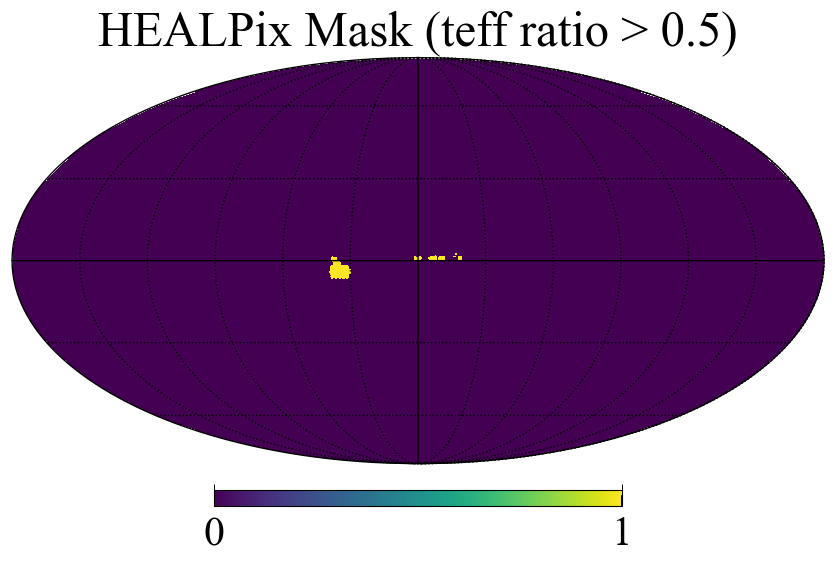

In [14]:
print("teff_ratio:",teff_ratio)
print("Resolution with N_side {} in healpix is {:.2} arcsec".format(N_side, hp.nside2resol(N_side, arcmin=True)*60))

RA_deg, Dec_deg = np.meshgrid(ra_bins, dec_bins)
RA_rad = np.radians(RA_deg.flatten())  # Convert to radians for HEALPy
Dec_rad = np.radians(Dec_deg.flatten())

theta = np.pi / 2 - Dec_rad
phi = RA_rad

pix_indices = hp.ang2pix(N_side, theta, phi)
teff_values = tot_t_eff_n540_fall.flatten()
max_teff_per_pixel = {}

for idx, teff in zip(pix_indices, teff_values):
    if idx in max_teff_per_pixel:
        max_teff_per_pixel[idx] = max(max_teff_per_pixel[idx], teff)
    else:
        max_teff_per_pixel[idx] = teff

healpix_mask = np.zeros(hp.nside2npix(N_side))

for pixel_idx, max_teff in max_teff_per_pixel.items():
    if max_teff > (texp_N540*teff_ratio):
        healpix_mask[pixel_idx] = 1.0

hp.mollview(healpix_mask, title="HEALPix Mask (teff ratio > {})".format(teff_ratio),
            rot=[0, 0], norm="hist", cmap='viridis', min=0, max=1)
hp.graticule()

# Compute the area of a single pixel in square degrees
pix_area_sq_deg = hp.nside2pixarea(N_side, degrees=True)
unmasked_pixels_count = np.sum(healpix_mask == 1)
total_unmasked_area_sq_deg = unmasked_pixels_count * pix_area_sq_deg
print(f"Total unmasked area: {total_unmasked_area_sq_deg:.2f} square degrees")

hp.write_map("N540_Fall_teff{}_2024.fits".format(teff_ratio), healpix_mask, overwrite=True)

# Combine N708 and N540 Spring fields

setting the output map dtype to [dtype('float64')]


Total unmasked area: 211.46 square degrees


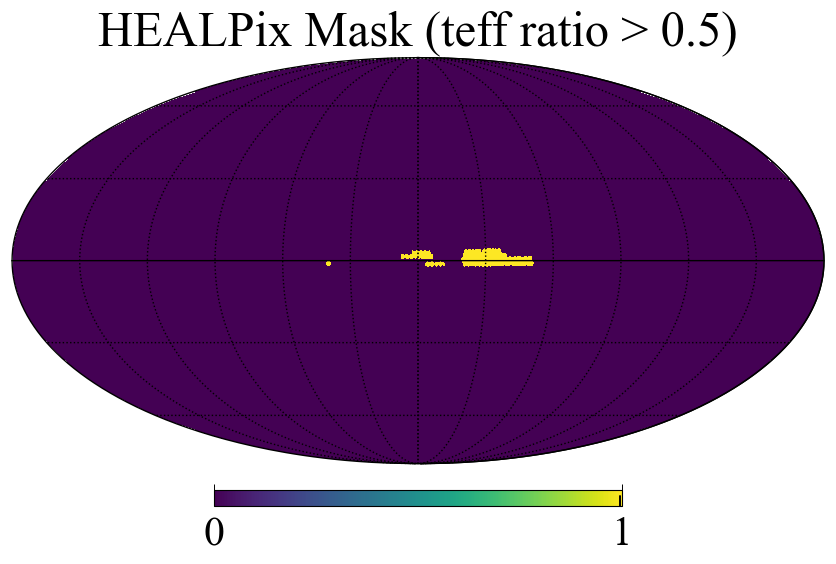

In [15]:
#Combine N708 and N540 Spring fields
mask1 = hp.read_map('N708_Spring_teff{}.fits'.format(teff_ratio))
mask2 = hp.read_map('N540_Spring_teff{}.fits'.format(teff_ratio))
combined_mask_and = (mask1 > 0) & (mask2 > 0)
combined_mask_and = combined_mask_and.astype(float)
pix_area_sq_deg = hp.nside2pixarea(N_side, degrees=True)
unmasked_pixels_count = np.sum(combined_mask_and == 1)

total_unmasked_area_sq_deg = unmasked_pixels_count * pix_area_sq_deg
print(f"Total unmasked area: {total_unmasked_area_sq_deg:.2f} square degrees")

hp.mollview(combined_mask_and, title="HEALPix Mask (teff ratio > {})".format(teff_ratio),
            rot=[-180, 0], norm="hist", cmap='viridis', min=0, max=1)
hp.graticule()

hp.write_map("Merian_Spring_teff{}.fits".format(teff_ratio), combined_mask_and, overwrite=True)

# Combine N708 and N540 Fall fields

setting the output map dtype to [dtype('float64')]


Total unmasked area: 22.33 square degrees


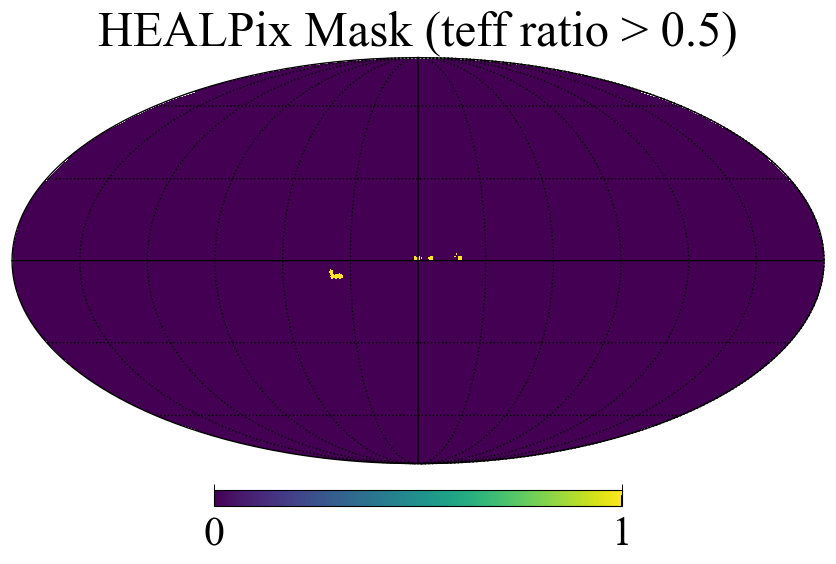

In [16]:
#Combine N708 and N540 Fall fields
mask1 = hp.read_map('N708_Fall_teff{}_2024.fits'.format(teff_ratio))
mask2 = hp.read_map('N540_Fall_teff{}_2024.fits'.format(teff_ratio))
combined_mask_and = (mask1 > 0) & (mask2 > 0)
combined_mask_and = combined_mask_and.astype(float)
pix_area_sq_deg = hp.nside2pixarea(N_side, degrees=True)
unmasked_pixels_count = np.sum(combined_mask_and == 1)
total_unmasked_area_sq_deg = unmasked_pixels_count * pix_area_sq_deg
print(f"Total unmasked area: {total_unmasked_area_sq_deg:.2f} square degrees")
hp.mollview(combined_mask_and, title="HEALPix Mask (teff ratio > {})".format(teff_ratio),
            rot=[0, 0], norm="hist", cmap='viridis', min=0, max=1)
hp.graticule()

hp.write_map("Merian_Fall_teff{}.fits".format(teff_ratio), combined_mask_and, overwrite=True)

# Combine Spring and Fall fields

Total unmasked area: 233.80 square degrees


setting the output map dtype to [dtype('float64')]


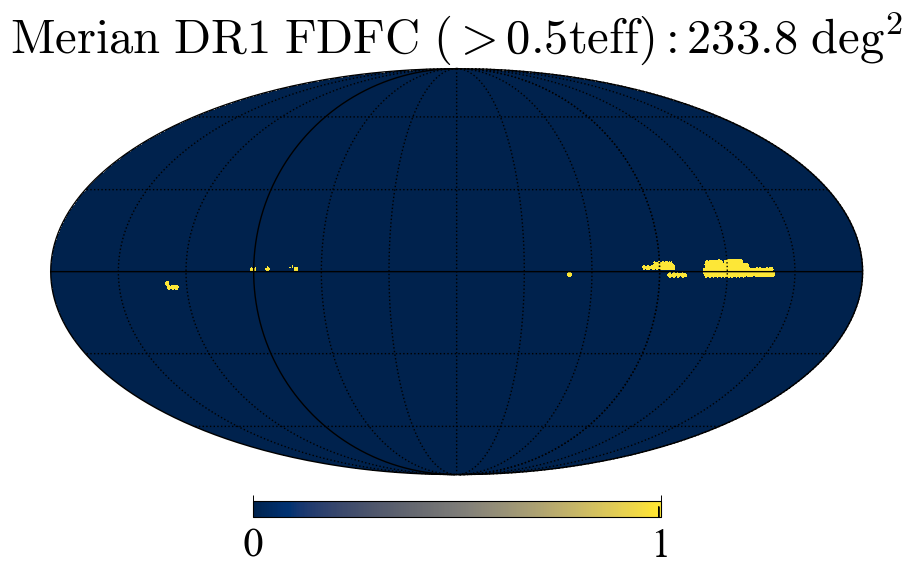

In [17]:
mask1 = hp.read_map('Merian_Spring_teff{}.fits'.format(teff_ratio))
mask2 = hp.read_map('Merian_Fall_teff{}.fits'.format(teff_ratio))
combined_mask_or = (mask1 > 0) | (mask2 > 0)
combined_mask_or = combined_mask_or.astype(float)
pix_area_sq_deg = hp.nside2pixarea(N_side, degrees=True)
unmasked_pixels_count = np.sum(combined_mask_or == 1)
total_unmasked_area_sq_deg = unmasked_pixels_count * pix_area_sq_deg
print(f"Total unmasked area: {total_unmasked_area_sq_deg:.2f} square degrees")

hp.mollview(combined_mask_or,
            title=r"$\rm Merian\ DR1\ FDFC\ (>{}teff) :{}\ deg^2$".format(teff_ratio,
                                                                          round(total_unmasked_area_sq_deg,2)),
            rot=[-90, 0], norm="hist", cmap='cividis', min=0, max=1,xsize=2000,bgcolor='white')
hp.graticule()
hp.write_map("Merian_DR1_teff{}.fits".format(teff_ratio), combined_mask_or, overwrite=True)
plt.savefig('Merian_DR1_FDFC_healpix_teff{}.png'.format(teff_ratio),dpi=300,bbox_inches='tight')

# Apply the mask to a fits catalog

In [18]:
# Load the galaxy catalog
catalog_filename = '/Users/yifei/Dropbox/merian/DR1/Merian_DR1_Sciuse_i23_objlist.fits'
galaxy_catalog = Table.read(catalog_filename)
ra = galaxy_catalog['coord_ra_Merian']  # Replace 'RA' with the actual column name if different
dec = galaxy_catalog['coord_dec_Merian']  # Replace 'DEC' with the actual column name if different
print(len(ra))

12731015


In [19]:
# Load the HEALPix map
healpix_map_filename = '/Users/yifei/Dropbox/merian/lambo/notebooks/healpix/Merian_DR1_teff0.5.fits'
healpix_map_5, header_5 = hp.read_map(healpix_map_filename, h=True, verbose=False)

/var/folders/tt/qbnmcq8j37l7h_t2xqgq4dv40000gn/T/ipykernel_86646/1826971959.py:3: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  healpix_map_5, header_5 = hp.read_map(healpix_map_filename, h=True, verbose=False)


In [21]:
nside = hp.npix2nside(len(healpix_map_5))
theta = np.radians(90.0 - dec)  # Convert DEC to theta in radians
phi = np.radians(ra)  # Convert RA to phi in radians
pixel_indices = hp.ang2pix(nside, theta, phi)
is_masked_5 = healpix_map_5[pixel_indices] > 0
print(len(is_masked_5))

# Save the teff flag as a column in the catalog
galaxy_catalog['IS_MASKED_0.5teff'] = is_masked_5
#galaxy_catalog.write('/Users/yifei/Dropbox/merian/DR1/Merian_DR1_Sciuse_i23_objlist_FDFC.fits',overwrite=True)

12731015
